In [1]:
setwd("E:/notebook/childhood_pneumonia")
library(survminer)
library(survival)
library(regplot)
library(cowplot)

Loading required package: ggplot2

Loading required package: ggpubr


Attaching package: 'survival'


The following object is masked from 'package:survminer':

    myeloma



Attaching package: 'cowplot'


The following object is masked from 'package:ggpubr':

    get_legend




In [2]:
data <- read.csv("./Results/2.model_data.csv",stringsAsFactors = F)
head(data,2)

,survival,Time,X5033.Urea,X5083.Uric.Acid..Urine,X5099.Hemoglobin,X5252.Oxygen.Saturation,X6473.Lipase
,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>
1,0,15,5.13,460,91,81.6,8
2,0,17,NA,NA,NA,90.9,NA


In [3]:
coxData<-data
res.cox <- coxph(Surv(Time, survival)~., data = coxData)
mucox<-summary(res.cox)
A<-as.matrix(res.cox$coefficients,ncol=1) 
B=as.matrix(data[,3:7])
score<-B%*%A
coxData$score=score[,1]

score.cox<-coxph(Surv(Time, survival)~score,data = coxData)
summary(score.cox)

Call:
coxph(formula = Surv(Time, survival) ~ score, data = coxData)

  n= 614, number of events= 87 
   (17 observations deleted due to missingness)

        coef exp(coef) se(coef)     z Pr(>|z|)    
score 1.0000    2.7183   0.1173 8.528   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

      exp(coef) exp(-coef) lower .95 upper .95
score     2.718     0.3679      2.16     3.421

Concordance= 0.701  (se = 0.039 )
Likelihood ratio test= 55.88  on 1 df,   p=8e-14
Wald test            = 72.73  on 1 df,   p=<2e-16
Score (logrank) test = 78.1  on 1 df,   p=<2e-16


In [4]:
res.cut <- surv_cutpoint(coxData, 
                         time = "Time", 
                         event = "survival",
                         variables = "score")

summary(res.cut) 

,cutpoint,statistic
,<dbl>,<dbl>
score,-1.52074,7.233743


In [5]:
coxData$fenzu<-"Low"
coxData$fenzu[which(coxData$score>(-1.521))]<-"High"
coxData$score<-coxData$score+1.521

Warning message:
"Removed 17 rows containing missing values (position_stack)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."


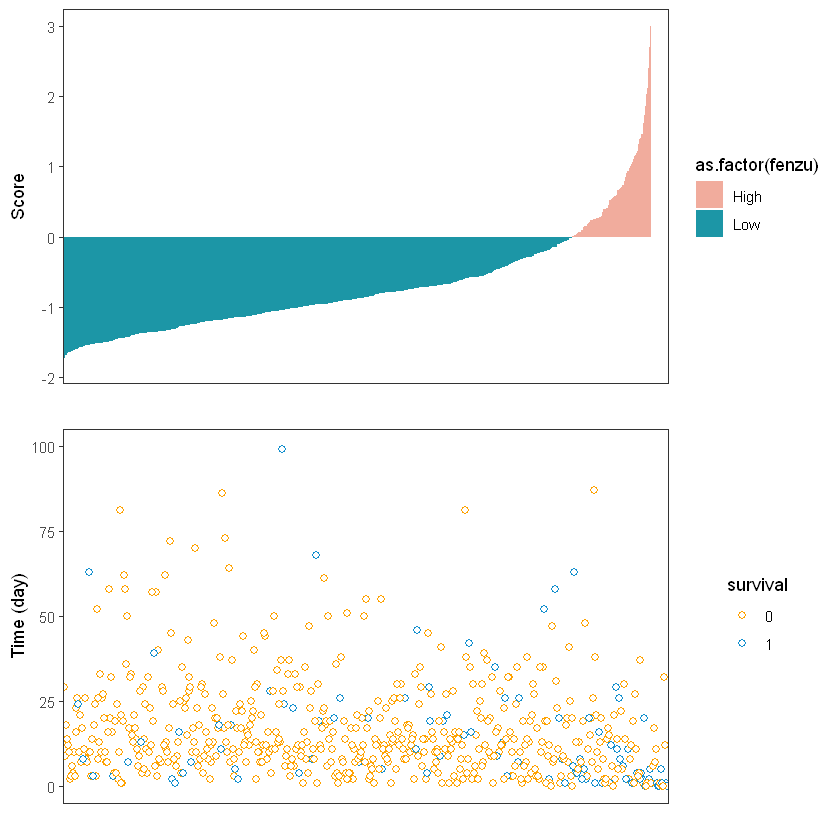

In [6]:
tcolor=c("#f1ac9d","#1c96a6")
z1<-ggplot(coxData, aes(x = reorder(rownames(coxData),score), y = score)) +
  geom_col(aes(fill = as.factor(fenzu)))+
  scale_fill_manual(values =tcolor)+
  xlab("")+ylab("Score")+
  theme_bw() + theme(panel.grid=element_blank(),
                     axis.text.x = element_blank(),
                     axis.ticks.x=element_blank())
sdf<-data.frame(id=reorder(rownames(coxData),score),time=coxData$Time,survival=as.factor(coxData$survival),fenzu=coxData$fenzu)
scolor<-c("#ffa200","#128fce")
z2<-ggscatter(sdf, x = "id", y = "time", color = "survival",shape = 21,
              palette = scolor)+
  ylim(0,100)+
  xlab("")+ylab("Time (day)")+
  theme_bw() + theme(panel.grid=element_blank(),
                     axis.text.x = element_blank(),
                     axis.ticks.x=element_blank())

z3 <- plot_grid(z1,z2, ncol = 1, align = "v")
z3

Call:
coxph(formula = Surv(Time, survival) ~ fenzu, data = coxData)

  n= 631, number of events= 95 

            coef exp(coef) se(coef)      z Pr(>|z|)    
fenzuLow -1.5143    0.2200   0.2206 -6.866 6.61e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

         exp(coef) exp(-coef) lower .95 upper .95
fenzuLow      0.22      4.546    0.1428    0.3389

Concordance= 0.647  (se = 0.028 )
Likelihood ratio test= 37.73  on 1 df,   p=8e-10
Wald test            = 47.14  on 1 df,   p=7e-12
Score (logrank) test = 56.72  on 1 df,   p=5e-14


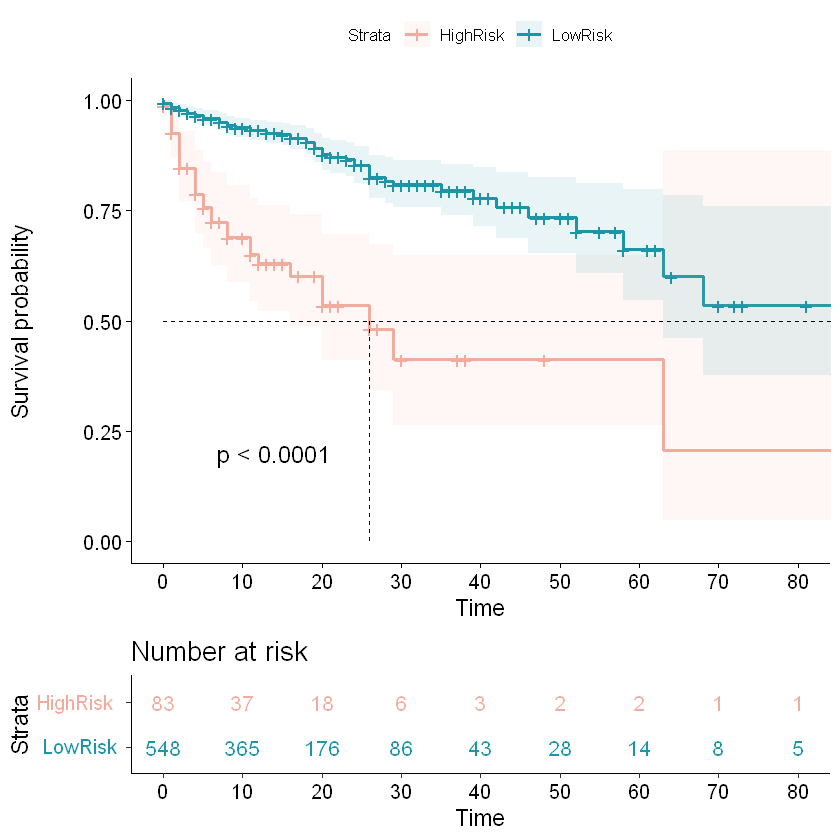

In [7]:
fit <- survfit(Surv(Time,survival)~fenzu,data = coxData)
summary(coxph(Surv(Time,survival)~fenzu,data = coxData))

p<-ggsurvplot(fit,
           pval = TRUE,#P-value
           risk.table = TRUE, # Add risk table
           risk.table.col = "strata", # Change risk table color by groups
           palette = tcolor,
           conf.int = T,
           conf.int.alpha=0.1, #显示置信区间
           surv.median.line = "hv", # 增加中位生存时间
           xlim=c(0,80),
           break.x.by = 10,
           legend.labs=c("HighRisk","LowRisk"))
p